# Retinoblastoma Detection using Hybrid Model

Retinoblastoma (Rb) is a tumor which is a primary intraocular malignancy of the retina that generally affects infants and children. The most common symptom of Rb is a white reflection emitted from the retina of the eye through the pupil called leukocoria. This disease must be treated at an early stage, otherwise it can lead to dangerous diseases. Based on this reason, early diagnosis will be very important, one of which is by detecting leukocoria. With the development of technology, image classification has become easier to do. Convolutional Neural Network (CNN) is an advanced image processing algorithm and Support Vector Machine (SVM) is an advanced algorithm for general classification. For this reason, the authors propose a CNN-SVM hybrid method to classify eyes with leukocoria. The model with the CNN-SVM hybrid method will extract features from the eye photographic image on the CNN layer and perform the final classification using the SVM algorithm.

## Import library
Before we begin to build the model, we need to import the necessary libraries.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import seaborn as sns
import pathlib
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image

## Load Dataset

Here we load the dataset that we have created

In [ ]:
#unzip dataset to dataset folder
os.system('unzip -o dataset/Small-Retinoblastoma-Dataset.zip -d dataset/')
#os.system('unzip -o Retinoblastoma-Dataset.zip') #run this row instead if you use google colab

In [9]:
# Current directory
cwd = os.getcwd()

# base directory for dataset
base_dir = os.path.join(cwd, 'dataset/Retinoblastoma-dataset/')

train_dir = os.path.join(base_dir, 'training') # training set directory
validation_dir = os.path.join(base_dir, 'validation') # validation set directory
test_dir = os.path.join(base_dir, 'testing') # testing set directory

In [10]:
# assign class names in training set to each variable
train_normal_eyes_dir = os.path.join(train_dir, 'normal')
train_retinoblastoma_dir = os.path.join(train_dir, 'retinoblastoma')

# assign class names in validation set to each variable
validation_normal_eyes_dir = os.path.join(validation_dir, 'normal')
validation_retinoblastoma_dir  = os.path.join(validation_dir, 'retinoblastoma')

# assign class names in testing set to each variable
test_normal_eyes_dir = os.path.join(test_dir, 'normal')
test_retinoblastoma_dir = os.path.join(test_dir, 'retinoblastoma')

# Count the number of images in each category
train_normal_eyes = len(os.listdir(train_normal_eyes_dir))
train_retinoblastoma = len(os.listdir(train_retinoblastoma_dir))
validation_normal_eyes = len(os.listdir(validation_normal_eyes_dir))
validation_retinoblastoma = len(os.listdir(validation_retinoblastoma_dir))
test_normal_eyes = len(os.listdir(test_normal_eyes_dir))
test_retinoblastoma = len(os.listdir(test_retinoblastoma_dir))


print(train_normal_eyes + train_retinoblastoma, ' Size of Trains')
print(validation_normal_eyes + validation_retinoblastoma, ' Size of Validations')
print(test_normal_eyes + test_retinoblastoma, ' Size of Tests')

185  Size of Trains
40  Size of Validations
27  Size of Tests


## image augmentation

Data augmentation is carried out with the aim of increasing the amount of data artificially by generating new data from existing data. Since the data in the dataset for the deep learning case is relatively small, data augmentation can also improve performance and also prevent overfitting.

In [11]:
# import ImageDataGenerator library
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# pre-process the data using ImageDataGenerator with vgg16 preprocessing function 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

Function for augmenting the image

In [12]:
 #use class_mode = 'categorical' if want to use multiclass classification'
 #use class_mode = 'binary' if want to use binary class classification

def data_augment(train_datagen, class_mode='categorical'):
 
  train_generator = train_datagen.flow_from_directory(
          train_dir,  # this is the target directory
          target_size=(224, 224),  # set image size to 224x224 for input
          batch_size=24, # set batch size to 24
          class_mode= class_mode # set to 'categorical' if want to use multiclass output
          )

  validation_generator = train_datagen.flow_from_directory(
          validation_dir,
          target_size=(224, 224),
          batch_size=24,
          class_mode= class_mode 
          )

  test_generator = train_datagen.flow_from_directory(
           test_dir,
           target_size=(224, 224),
           batch_size=24,
           class_mode=class_mode
           )

  return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = data_augment(train_datagen, 'categorical')

Found 184 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


Here we see we have 2 classes, namely positive and negative. The positive class is the image of the eye with retinoblastoma and the negative class is the image of the normal eye. With 184 images training data, 40 images validation data, and 25 images for the test data. 

----------------------------


## looking at the augmented data

We are looking at the data that has been augmented, as we can see that the data differ a bit from original data. The data has been augmented with rotation, zoom, and horizontal flip.

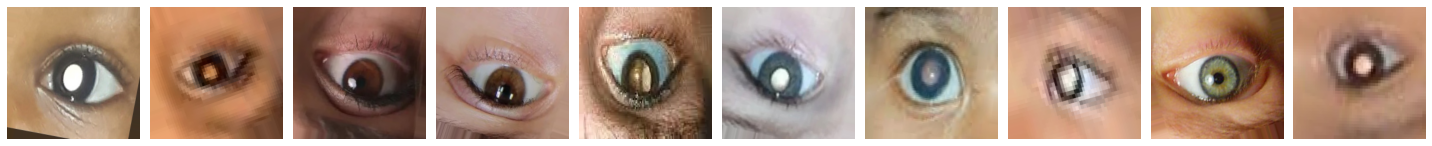

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [61]:
img, labels = next(train_generator)

#function for plotting images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(img)
print(labels[0:10])

## Create the model

We propose a CNN-SVM hybrid model to classify retinoblastoma eyes. CNN will be used as feature extraction from images and SVM will be used as the final classification layer. The architecture of the CNN-SVM hybrid consist of Input layer, Convolutional layer, Max Pooling layer, Flatten layer, dropout layer, and Classification layer.  



### Function for creating the model

In [14]:
def create_model():

    #setting parameters for svm classification layer
    kernel_regularizer = tf.keras.regularizers.l2(0.01)
    activation_funct = 'softmax' 
    loss = 'squared_hinge'
    
    #create model  
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(2, kernel_regularizer = kernel_regularizer, activation=activation_funct)
      ])

  #compile model 
    model.compile(loss = loss, 
                optimizer=tf.optimizers.Adam(),
                metrics=['accuracy'])
  
  #return model
    return model

### Function for training the model

In [15]:
# train the model
def train_model(model, epochs, train_generator, validation_generator):


  #write training history to csv format
  saved_path = os.path.join('training_history', 'model_training.log')
  csv_logger = tf.keras.callbacks.CSVLogger(saved_path, separator=',', append=False)
  
  return model.fit(
         train_generator,
         epochs=epochs, 
         validation_data=validation_generator,
         verbose=2,
         callbacks=[csv_logger])

We use both function above to create and train the model

## Training the Model

After we create the model and the function for training the model, we can train the model using the function that we have created before to train the model. We train the model using 20 epochs and we also use the validation data to see how well our model perform on untrained data in each epochs.

In [ ]:
cnnsvm_retinoblastoma_model = create_model()
history_binary_cnnsvm = train_model(cnnsvm_retinoblastoma_model, 20, train_generator, validation_generator)

## Saving and Loading the Model

After we've done training the model, we save the model so we can use it later. We can also load the model that we have saved before.

In [19]:
#Saving the Model
cnnsvm_retinoblastoma_model.save("Saved_model/cnnsvm_retinoblastoma_model.h5")

#Loading the Model
cnnsvm_retinoblastoma_model = tf.keras.models.load_model('Saved_model/cnnsvm_retinoblastoma_model.h5')

## Visualizing training process

To see how well our model perform during the training process, we can visualize the accuracy and loss of the training data and validation data in every epoch.

### Loss Plot

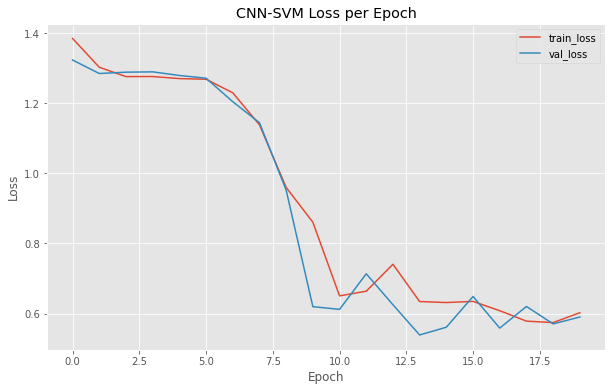

In [6]:
# plot the training loss and accuracy on every epochs

log_data = pd.read_csv('training_history/model_training.log', sep=',', engine='python')

plt.style.use("ggplot")
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 20), log_data["loss"], label="train_loss")
plt.plot(np.arange(0, 20), log_data["val_loss"], label="val_loss")
plt.title("CNN-SVM Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
#plt.savefig('plot/CNN-SVM/loss_plot.png')
plt.show()

### Accuracy Plot

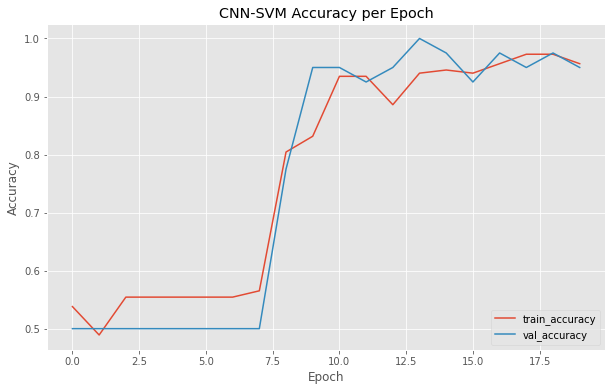

In [8]:
# plot the training loss and accuracy on every epochs

log_data = pd.read_csv('training_history/model_training.log', sep=',', engine='python')

plt.style.use("ggplot")
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, 20), log_data["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 20), log_data["val_accuracy"], label="val_accuracy")
plt.title("CNN-SVM Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
#plt.savefig('plot/CNN-SVM/Accuracy_plot.png')
plt.show()

As can be seen in the both image, the accuracy graph and loss graph even though it looks a little fluctuating, but the graph shows good results where the accuracy of the training data and validation data manages to be above 90% and the model also produce a low loss score after the 8th iteration. Besides that, the graph also does not show any symptoms of overfitting

## Testing the model
After the model is trained, we can test the model with the test data to see the prediction results and the performance of our model. To measure the performance of the model, we use four metrics namely precision, recall, accuracy, and f1-score 

In [25]:
#Function for predicting the class of the image
def predicted(model, target_directory, target):
  
  normal = 0
  retinoblastoma = 0

  try:
    #iterate through the retinoblastoma test directory
    dir = os.path.join(target_directory, target)
    for images_path in os.listdir(dir):
        path = images_path

        if path == '.DS_Store' or path.endswith('.heic'):
            continue

        #load image
        img = tf.keras.preprocessing.image.load_img(os.path.join(dir, path), target_size=(224,224))
        x =  tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        #predict image
        images = np.vstack([x])
        classes = model.predict(images, batch_size=10)
        
        if round(float(classes[0][0])) == 1:
          normal += 1
        elif round(float(classes[0][1])) == 1:
          retinoblastoma += 1
        
    #print total case and predicted case
    total_case = retinoblastoma + normal
    predicted_normal = normal
    predicted_retinoblastoma = retinoblastoma

    if target == 'normal':
      #print true negative, and false positive rate
      true_negative = predicted_normal
      false_positive = predicted_retinoblastoma
      return true_negative, false_positive
    
    if target == 'retinoblastoma':
      #print true negative, and false positive rate
      true_positive = predicted_retinoblastoma
      false_negative = predicted_normal
      return true_positive, false_negative
 
  except:
    pass

#Function for calculating model  metrics
def metrics(model, target_directory):
  TN, FP = predicted(model, target_directory, 'normal')
  TP, FN = predicted(model, target_directory, 'retinoblastoma')

  #calculating recall
  Recall = TP / (TP + FN) * 100
  print("\nRecall: {:.1f}%".format(Recall))

  #calculating precision
  Precision = TP/(TP + FP) * 100
  print("Precision: {:.1f}%".format(Precision))

  #calculating accuracy
  Accuracy = (TP + TN) / (TP+TN+FP+FN) * 100
  print("Accuracy: {:.1f}%".format(Accuracy))

  #calculating F1 score
  F1_score = (2 * Precision * Recall) / (Precision + Recall)
  print("F1 score: {:.1f}%".format(F1_score))

here we test the model that we have saved with the test data

In [27]:
#evaluate model prediction result
#evaluate testing data in normal directory
predicted_normal_normal_dir, predicted_retinoblastoma_normal_dir = predicted(cnnsvm_retinoblastoma_model, test_dir, 'normal')
#evaluate testing data in retinoblastoma directory
predicted_retinoblastoma_retinoblastoma_dir, predicted_normal_retinoblastoma_dir = predicted(cnnsvm_retinoblastoma_model, test_dir, 'retinoblastoma')

metrics(cnnsvm_retinoblastoma_model, test_dir)

#print prediction results
#in normal eye directory
print('\nTotal normal case: ', predicted_normal_normal_dir + predicted_retinoblastoma_normal_dir)
print('Total case predicted correctly: ', predicted_normal_normal_dir)
print('Total case predicted incorrectly: ', predicted_retinoblastoma_normal_dir)
print('')
#in retinoblastoma eye directory
print('Total retinoblasma case: ', predicted_normal_retinoblastoma_dir + predicted_retinoblastoma_retinoblastoma_dir)
print('Total case predicted correctly: ', predicted_retinoblastoma_retinoblastoma_dir)
print('Total case predicted incorrectly: ', predicted_normal_retinoblastoma_dir)


1/1 [==============================] - 0s 11ms/step

Recall: 100.0%
Precision: 83.3%
Accuracy: 92.3%
F1 score: 90.9%

Total normal case:  16
Total case predicted correctly:  14
Total case predicted incorrectly:  2

Total retinoblasma case:  10
Total case predicted correctly:  10
Total case predicted incorrectly:  0


Recall = 100.0%,
Precision = 83.3%,
Accuracy = 92.3%,
F1 score = 90.9%,

Total normal case =  16,
normal case predicted correctly =  14,
normal case predicted incorrectly =  2,


Total retinoblastoma case =  10,
retinoblastoma case predicted correctly =  10,
retinoblastoma case predicted incorrectly =  0,

## Confussion matrix

1/1 [==============================] - 0s 15ms/step


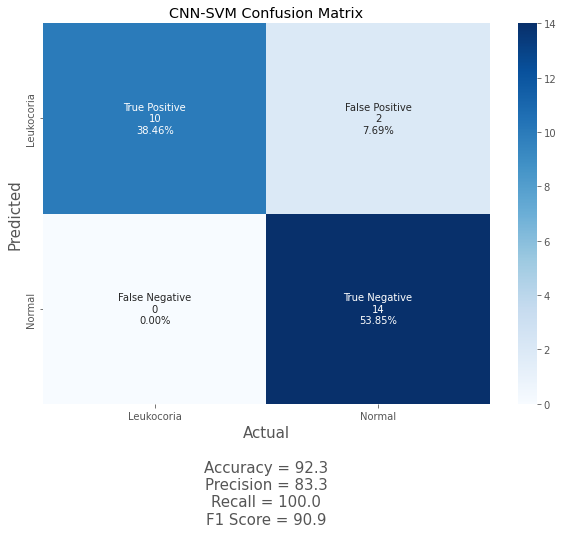

In [28]:
#plot confussion matrix
TN, FP = predicted(cnnsvm_retinoblastoma_model, test_dir, 'normal')
TP, FN = predicted(cnnsvm_retinoblastoma_model, test_dir, 'retinoblastoma')

Recall = TP / (TP + FN) * 100
Precision = TP/(TP + FP) * 100
Accuracy = (TP + TN) / (TP+TN+FP+FN) * 100
F1_score = (2 * Precision * Recall) / (Precision + Recall)

confusion_matrix = np.array([[TP, FP], [FN, TN]])
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ["Leukocoria", "Normal"]],
                    columns = [i for i in ["Leukocoria", "Normal"]])

group_names = ['True Positive','False Positive','False Negative','True Negative']

group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

stats_text = "\n\nAccuracy = {:0.1f}\nPrecision = {:0.1f}\nRecall = {:0.1f}\nF1 Score = {:0.1f}".format(
                Accuracy,Precision,Recall,F1_score)

plt.figure(figsize = (10,7))
plt.title('CNN-SVM Confusion Matrix')
sns.heatmap(df_cm, annot=labels, cmap='Blues' , fmt='')
plt.ylabel('Predicted', fontsize=15)
plt.xlabel('Actual' + stats_text, fontsize=15)
#plt.savefig('plot/CNN-SVM/confusion_matrix.png')
plt.show()

From the matrix above a recall value of 100% indicates the model can properly classify positive classes (retinoblastoma), the recall value will be very important because in detecting symptoms of a disease, the possibility of the model incorrectly predicting positive cases should be minimal. The F1-Score value of 90.9% also shows a balanced value between recall and precision.

## Convert the model to tflite format

At the end, we convert the model to tflite format so that the model can be deployed for mobile application.

In [ ]:
def convert(model):

  #Convert the model.
  converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  tflite_model = converter.convert()

  # Save the model.
  with open('Saved_model/cnnsvm_retinoblastoma_model.tflite', 'wb') as f:
    f.write(tflite_model)

model = train.load_model('Saved_model/cnnsvm_retinoblastoma_model.h5')
convert(model)